# Combinatorial library properties

## Aim of this notebook

In this notebook we want to analyze properties of the combinatorial library:

1. Recombined ligands compliant with Lipinski's rule of five (criteria) in comparison to KLIFS and PKIDB ligands
2. Recombined ligand sizes (number of heavy atoms)

Note that the combinatorial library is stored as `json` file (~6M molecules). The data needed for this notebook was extracted previously in notebook `4_1_combinatorial_library_data.ipynb` for easy and fast access here.

## Table of contents

1. Lipinski's rule of five
2. Recombined ligand size

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path

import ijson
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem

from utils import get_original_ligands, get_ro5_from_mol, read_fragment_library

## 1. Lipinski's rule of five

In [3]:
properties = pd.read_csv(
    '../data/combinatorial_library/properties.csv',
    header=None,
    index_col=0,
    squeeze=True
)
properties

0
mw           3224102
logp         3973927
hbd          6733220
hba          6029791
lipinski     4285753
n_ligands    6752232
Name: 1, dtype: int64

### Recombined ligands

In [4]:
ro5_comb = round(
    properties[['mw', 'logp', 'hbd', 'hba', 'lipinski']] / properties['n_ligands'] * 100, 
    0
)
ro5_comb = ro5_comb.astype('int')
ro5_comb

0
mw           48
logp         59
hbd         100
hba          89
lipinski     63
Name: 1, dtype: int64

### PKIDB ligands

PKIDB ligands: approved and investigorial kinase inhibitors

In [5]:
data_pkidb = pd.read_csv('https://raw.githubusercontent.com/dominiquesydow/pkidb_klifs/master/results/pkidb_20200218.csv', index_col=0)
print(f'Number of ligands in PKIDB data: {data_pkidb.shape[0]}')

Number of ligands in PKIDB data: 218


In [6]:
data_pkidb.head(2)

,INN_Name,BrandName,Phase,Applicants,LigID,pdbID,Type,RoF,MW,LogP,...,Targets,Kinase_families,First_Approval,SC_Patent,Chirality,Synonyms,FDA_approved,Melting_points_C,Canonical_Smiles,InChIKey
0,Leniolisib,NaN,0.0,Novartis,9NQ,['5o83'],NaN,0,450.2,2.9,...,NaN,NaN,NaN,NaN,Single Stereoisomer,"['CDZ173-NX', 'Leniolisib']",NaN,NaN,CCC(=O)N1CC[C@@H](C1)Nc2c3c(ncn2)CCN(C3)c4cc(c...,MWKYMZXCGYXLPL-ZDUSSCGKSA-N
1,Nemiralisib,NaN,0.0,GlaxosmithKline,VVX,['5ae8'],NaN,0,440.2,4.9,...,NaN,NaN,NaN,NaN,Single Stereoisomer,"['GSK2269557A', 'GSK-2269557', 'Nemiralisib']",NaN,NaN,CC(C)N1CCN(CC1)Cc2cnc(o2)c3cc(cc4c3cn[nH]4)c5c...,MCIDWGZGWVSZMK-UHFFFAOYSA-N


In [7]:
ro5_pkidb = round(
    data_pkidb.Canonical_Smiles.apply(
        Chem.MolFromSmiles
    ).apply(get_ro5_from_mol).sum() / data_pkidb.shape[0] * 100, 
    0
)
ro5_pkidb = ro5_pkidb.astype('int')
ro5_pkidb

mw           70
logp         74
hbd         100
hba          99
lipinski     85
dtype: int64

### Original ligands

In [8]:
data_klifs = pd.read_json('../data/fragment_library/original_ligands.json')
print(f'Number of original KLIFS ligands: {data_klifs.shape[0]}')

Number of original KLIFS ligands: 2553


In [9]:
data_klifs.head(2)

,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...


In [10]:
data_klifs.subpocket[0]

['AP', 'GA', 'B2']

In [11]:
ro5_klifs = round(
    data_klifs.smiles.apply(
        Chem.MolFromSmiles
    ).apply(get_ro5_from_mol).sum() / data_klifs.shape[0] * 100, 
    0
)
ro5_klifs = ro5_klifs.astype('int')
ro5_klifs

mw          88
logp        94
hbd         99
hba         99
lipinski    97
dtype: int64

### Plot properties

In [12]:
# Collect data in one DataFrame
bar_data = pd.DataFrame(
    {
        f'Recombined ligands (#{properties["n_ligands"]})': ro5_comb, 
        f'Original KLIFS ligands (#{data_klifs.shape[0]})': ro5_klifs, 
        f'PKIDB ligands (#{data_pkidb.shape[0]})': ro5_pkidb
    }
)
bar_data = bar_data.astype('int32')
bar_data

,Recombined ligands (#6752232),Original KLIFS ligands (#2553),PKIDB ligands (#218)
0,,,
mw,48,88,70
logp,59,94,74
hbd,100,99,100
hba,89,99,99
lipinski,63,97,85


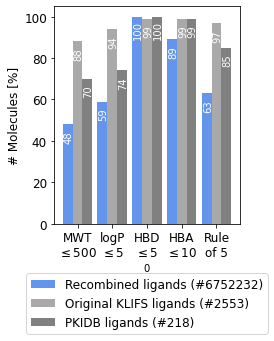

In [13]:
# Plot data
ax = bar_data.plot(
    kind='bar',
    width=0.85,
    rot=0,
    figsize=(3.33, 4),
    color=['cornflowerblue', 'darkgrey', 'grey']
)

# Edit labels for y axis and x/y ticks
plt.ylabel('# Molecules [%]', fontsize=12)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$', 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=12, loc='upper left')
legend = plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5,-.2),
           fontsize=12
          )

# Add percentages to bars
bars = ax.patches
bar_labels = bar_data.transpose().values.flatten()
for bar, label in zip(bars, bar_labels):
    
    plt.text(
        bar.get_x() + bar.get_width() / 1.6, 
        bar.get_height() - 6,
        label, 
        ha='center', 
        va='center', 
        fontsize=10,
        color='white',
        rotation=90
    )

In [14]:
ax.get_figure().savefig(
    'figures/combinatorial_library_ro5.pdf',
    bbox_extra_artists=(legend,),
    bbox_inches='tight'
)

## 2. Recombined ligand size

In [15]:
n_atoms = pd.read_csv('../data/combinatorial_library/n_atoms.csv', header=None).squeeze()
len(n_atoms)

6752232

Text(0.5, 0, 'Number of heavy atoms')

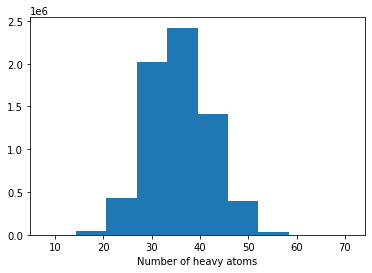

In [16]:
plt.hist(n_atoms)
plt.xlabel('Number of heavy atoms')

In [17]:
# Delete object (since very large with ~6M entries)
del n_atoms